# Team 7 Project - Yellow Taxi Dataset



## Table of Contents

1. [Introduction](#1.-Introduction)
2. [Imports](#2.-Imports)
3. [Data-Preperation](#3.-Data-Preperation)
    - [3.1 Weather-Dataset](#3.1-Clean-up-of-the-Weather-Data-Set)
    - [3.2 Taxi-Dataset](#3.2-Clean-up-of-the-Yellow-Taxi-Data-Set)
    - [3.3 Taxi-Zones](#3.3-Clean-up-of-the-Taxi-Zones)
    - [3.4 Merged Zones + Trip](#3.4-Merge-of-zones-and-trips)
    - [3.5 Merge of Weather + Trip](#3.5-Merge-of-weather-and-trips)
4. [Descriptive Analysis](#4.-Descriptive-Analysis)
    - [4.1 Temperature](#4.1-Number-of-rides-according-to-the-temperature)
    - [4.2 Common Pickup-Zones](#4.2-Most-Common-Pickup-Zones)
        - [4.2.1 Common Pickup Heatmap](#4.2.1-Heatmap)
    - [4.3 Common Dropoff-Zones](#4.3-Most-Common-Dropoff-Zones)
    - [4.4 Most Common Pairs](#4.4-
    - [4.5 Temporal Trip Patterns](#4.4-Temporal-Trip-Patterns)
        - [4.5.1 Time-of-Day Usage](#4.4.1-Time-of-Day-Usage)
        - [4.5.2 Day-of-Week Usage](#4.4.2-Day-of-Week-Usage)
5. [Predictive Models](#5.-Predictive-Models)



## 1. Introduction

For our team project, we have chosen to analyze the <a href="https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page">NYC Yellow Taxi Dataset January (2021)</a>, which contains collected data of taxi trips in New York City. The dataset offers information such as pickup and drop-off times, trip distances, fares, passenger counts, and various surcharges. In the following, we will point out, which features we are going to include and which target we are going to predict.


## Context and Relevance

Understanding trip counts provides valuable insights for various stakeholders:
* Shared `mobility providers` can use demand patterns to optimize fleet allocation, predict peak times, and identify opportunities for new services
* City `governments` can leverage this data to improve traffic management, urban planning, and environmental policies by understanding when and where taxi demand is highest
* For `society` at large, improved knowledge of taxi usage contributes to more efficient transportation networks, reduced congestion and emissions, and better mobility services for residents and visitors

The primary goal of this analysis is to identify temporal and spatial patterns in taxi demand through trip count metrics. Key questions include:

* Are there weather trends in the trip data?
* Which neighborhoods have the most frequent taxi activity?
* Are there any Temporal Trends?





## *2. Imports*

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

## 3. Data-Preperation

### *3.1 Clean-up of the Weather Data-Set*

In [3]:
weather = pd.read_csv('NYC_Weather_2016_2022.csv')

In our <a href="https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022?resource=download">NYC weather dataset</a>, we initially filtered out all data that does not pertain to January 2021, since our primary dataset is also focused exclusively on that month.

Also we dropped some columns because of their limited relevance for our predictive tasks:

* `cloudcover (%)`
* `cloudcover_low (%)`
* `cloudcover_mid (%)`
* `cloudcover_high (%)`
* `winddirection_10m (°)`

All of the cloud cover levels do only have minimal impact on taxi demand or passenger behavior. Since it tends to correlate with other more impactful weather features such as precipitation and temperature, it does not provide significant added value for our models. <br>
`winddirection` also wont influence the taxi patterns in a meaningful way within an urban environtment like NYC.



In [4]:
weather = weather.loc[weather['time'].str[:7] == "2021-01"]
weather['time'] = pd.to_datetime(weather['time'])
columns_to_drop = [
    'cloudcover (%)',
    'cloudcover_low (%)',
    'cloudcover_mid (%)',
    'cloudcover_high (%)',
    'winddirection_10m (°)'
]
weather = weather.drop(columns=columns_to_drop)

weather

,time,temperature_2m (°C),precipitation (mm),rain (mm),windspeed_10m (km/h)
43848,2021-01-01 00:00:00,4.3,0.0,0.0,9.9
43849,2021-01-01 01:00:00,3.9,0.0,0.0,9.0
43850,2021-01-01 02:00:00,3.3,0.0,0.0,8.9
43851,2021-01-01 03:00:00,1.4,0.0,0.0,7.8
43852,2021-01-01 04:00:00,0.8,0.0,0.0,9.2
...,...,...,...,...,...
44587,2021-01-31 19:00:00,-4.4,0.0,0.0,6.2
44588,2021-01-31 20:00:00,-3.9,0.0,0.0,7.6
44589,2021-01-31 21:00:00,-4.0,0.0,0.0,9.4
44590,2021-01-31 22:00:00,-4.3,0.0,0.0,9.4


### *3.2 Clean-up of the Yellow Taxi Data-Set* 

As a first step, we loaded the Yellow Taxi dataset into the variable `TripData` to make it available for further processing


In [5]:
TripData = pd.read_parquet('yellow_tripdata_2021-01.parquet', engine='pyarrow')
TripData

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


 #### The following columns have been removed: 
 * `store_and_fwd_flag`
 * `airport_fee`
 * `RatecodeID`
 * `payment_type`
 * `fare_amount`
 * `extra`
 * `mta_tax`
 * `tip_amount`
 * `tolls_amount`
 * `improvement_surcharge`
 * `total_amount`
 * `congestion_surcharge`
 
 
The `store_and_fwd_flag column` indicates whether the trip record was temporarily stored in the vehicle's memory before being sent to the vendor, also known as "store and forward," due to the vehicle's lack of server connectivity at the time of the trip. Since this information does not contribute to our analysis, we decided to exclude this column. 
<br>
`VendorID`, `payment_type`, `airport_fee`, `fare_amount`, `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge`, `total_amount`, `congestion_surcharge` all represent detailed financial components of each trip. While useful for fare analysis or revenue modeling, they are not required for understanding the frequency or distribution of trips. Consequently, we decided to drop these columns to simplify the dataset and focus solely on trip counts.
<br>

#### The following rows have been removed:

All rows containing 'NaN' <br>

For further information, please refer to the <a href="https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf">Yellow Taxi Data Dictonary</a>

In [6]:
cols_to_drop = [
    'store_and_fwd_flag',
    'airport_fee',
    'RatecodeID',
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'congestion_surcharge',
    'VendorID'
]


TripData.drop(columns=cols_to_drop, inplace=True)
TripData = TripData.dropna()


TripData = TripData.copy() ## Added for SettingWithCopyWarning

TripData['PULocationID'] = TripData['PULocationID'].astype(int) ## Checking if LocationIDs are Integers
TripData['DOLocationID'] = TripData['DOLocationID'].astype(int)


TripData

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,142,43
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,238,151
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,132,165
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,138,132
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,68,33
...,...,...,...,...,...,...
1271412,2021-01-31 23:58:47,2021-02-01 00:04:40,3.0,0.81,41,74
1271413,2021-01-31 23:07:54,2021-01-31 23:19:42,1.0,3.81,113,141
1271414,2021-01-31 23:30:45,2021-01-31 23:35:13,1.0,1.32,233,237
1271415,2021-01-31 23:09:52,2021-01-31 23:51:56,2.0,10.56,56,68


Since one of our future prediction tasks requires the duration of the trip, we have added a new column, `trip_time_minutes`, by subtracting the `tpep_pickup_datetime` from the `tpep_dropoff_datetime`. We also resorted the dataset so that the trip duration appears after the pickup and drop-off columns

In [7]:

# Calculate the trip time in minutes
TripData['trip_time_minutes'] = (TripData['tpep_dropoff_datetime'] - TripData['tpep_pickup_datetime']).dt.total_seconds() / 60

# Resorting the dataset and insert trip time behind pu/do 
col = TripData.pop('trip_time_minutes')
TripData.insert(3, 'trip_time_minutes', col)

In [8]:
TripData

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_time_minutes,trip_distance,PULocationID,DOLocationID
0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,6.033333,2.10,142,43
1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.983333,0.20,238,151
2,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,27.600000,14.70,132,165
3,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,15.216667,10.60,138,132
4,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,16.533333,4.94,68,33
...,...,...,...,...,...,...,...
1271412,2021-01-31 23:58:47,2021-02-01 00:04:40,3.0,5.883333,0.81,41,74
1271413,2021-01-31 23:07:54,2021-01-31 23:19:42,1.0,11.800000,3.81,113,141
1271414,2021-01-31 23:30:45,2021-01-31 23:35:13,1.0,4.466667,1.32,233,237
1271415,2021-01-31 23:09:52,2021-01-31 23:51:56,2.0,42.066667,10.56,56,68


### *3.3 Clean-up of the Taxi-Zones*

In [9]:
zones = gpd.read_file("NYC Taxi Zones.geojson")

To analyse common pick up and drop off locations in the future, we have also added the `NYC Taxi Zones` Dataset. We dropped `shape_area`, `objectid` and `shape_leng` since we dont need this information in the future.

In [10]:
zones = zones[['location_id', 'zone', 'borough', 'geometry']].copy()
zones

,location_id,zone,borough,geometry
0,1,Newark Airport,EWR,"MULTIPOLYGON (((-74.18445 40.695, -74.18449 40..."
1,2,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ..."
3,4,Alphabet City,Manhattan,"MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ..."
4,5,Arden Heights,Staten Island,"MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ..."
...,...,...,...,...
258,256,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ..."
259,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ..."
260,260,Woodside,Queens,"MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ..."
261,261,World Trade Center,Manhattan,"MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ..."


### *3.4 Merge of zones and trips*

To analyse demand in certain areas later, we will merge `zones`  with the `TripData` <br>


Since we dont need most of the columns from our `TripData` Dataset, we only included a few. Also we renamed certain columns for clarity. 


In [11]:
zones = zones.rename(columns={'location_id': 'LocationID'})

zones['LocationID'] = zones['LocationID'].astype(int)           ## The PU/DOLocations where int64, while 
TripData['PULocationID'] = TripData['PULocationID'].astype(int) ## LocationID had the type object
TripData['DOLocationID'] = TripData['DOLocationID'].astype(int) ## so change both to int64

TripData_zones = TripData.merge(                                ## merge pickup
    zones[['LocationID', 'zone', 'borough', 'geometry']],
    left_on='PULocationID',
    right_on='LocationID',
    how='left',
    suffixes=('', '_pickup')
)

TripData_zones = TripData_zones.merge(                          ## merge dropoff
    zones[['LocationID', 'zone', 'borough', 'geometry']],
    left_on='DOLocationID',
    right_on='LocationID',
    how='left',
    suffixes=('', '_dropoff')
)

In [12]:
TripZones = TripData_zones.rename(columns={               ## rename
    'zone': 'pickup_zone',
    'borough': 'pickup_borough',
    'geometry': 'pickup_geometry',
    'geometry_dropoff': 'dropoff_geometry'
})

TripZones = TripZones[[                              ## resort + drop certain columns
    'passenger_count',
    'tpep_pickup_datetime',
    'pickup_zone',
    'pickup_borough',
    'pickup_geometry',
    'tpep_dropoff_datetime',
    'zone_dropoff',
    'borough_dropoff',
    'dropoff_geometry'
]]

TripZones

,passenger_count,tpep_pickup_datetime,pickup_zone,pickup_borough,pickup_geometry,tpep_dropoff_datetime,zone_dropoff,borough_dropoff,dropoff_geometry
0,1.0,2021-01-01 00:30:10,Lincoln Square East,Manhattan,"MULTIPOLYGON (((-73.98148 40.76773, -73.98155 ...",2021-01-01 00:36:12,Central Park,Manhattan,"MULTIPOLYGON (((-73.97255 40.7649, -73.97301 4..."
1,1.0,2021-01-01 00:51:20,Upper West Side North,Manhattan,"MULTIPOLYGON (((-73.96884 40.78597, -73.96934 ...",2021-01-01 00:52:19,Manhattan Valley,Manhattan,"MULTIPOLYGON (((-73.96371 40.79301, -73.96418 ..."
2,1.0,2021-01-01 00:43:30,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ...",2021-01-01 01:11:06,Midwood,Brooklyn,"MULTIPOLYGON (((-73.96015 40.62892, -73.95996 ..."
3,0.0,2021-01-01 00:15:48,LaGuardia Airport,Queens,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...",2021-01-01 00:31:01,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ..."
4,1.0,2021-01-01 00:31:49,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ...",2021-01-01 00:48:21,Brooklyn Heights,Brooklyn,"MULTIPOLYGON (((-73.99619 40.70338, -73.99514 ..."
...,...,...,...,...,...,...,...,...,...
1271960,1.0,2021-01-31 23:07:54,Greenwich Village North,Manhattan,"MULTIPOLYGON (((-73.99136 40.72756, -73.99155 ...",2021-01-31 23:19:42,Lenox Hill West,Manhattan,"MULTIPOLYGON (((-73.96178 40.75988, -73.96197 ..."
1271961,1.0,2021-01-31 23:30:45,UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((-73.96547 40.75194, -73.96532 ...",2021-01-31 23:35:13,Upper East Side South,Manhattan,"MULTIPOLYGON (((-73.96613 40.76218, -73.96658 ..."
1271962,2.0,2021-01-31 23:09:52,Corona,Queens,"MULTIPOLYGON (((-73.85361 40.7475, -73.85325 4...",2021-01-31 23:51:56,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ..."
1271963,2.0,2021-01-31 23:09:52,Corona,Queens,"MULTIPOLYGON (((-73.85131 40.74984, -73.85443 ...",2021-01-31 23:51:56,East Chelsea,Manhattan,"MULTIPOLYGON (((-74.00202 40.74044, -74.00252 ..."


### *3.5 Merge of weather and trips*

In [13]:
TripData['tpep_pickup_datetime'] = TripData['tpep_pickup_datetime'].astype('datetime64[ns]')
weather['time'] = weather['time'].astype('datetime64[ns]')

TripData_sorted = TripData.sort_values('tpep_pickup_datetime')
weather_sorted = weather.sort_values('time')

TripData_weather = pd.merge_asof(
    TripData_sorted,
    weather_sorted[['time', 'temperature_2m (°C)', 'rain (mm)']],
    left_on='tpep_pickup_datetime',
    right_on='time',
    direction='backward'
)

TripData_weather = TripData_weather.dropna()
TripData_weather

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_time_minutes,trip_distance,PULocationID,DOLocationID,time,temperature_2m (°C),rain (mm)
20,2021-01-01 00:00:04,2021-01-01 00:10:58,1.0,10.900000,2.35,48,141,2021-01-01 00:00:00,4.3,0.0
21,2021-01-01 00:00:18,2021-01-01 00:07:17,2.0,6.983333,0.90,170,233,2021-01-01 00:00:00,4.3,0.0
22,2021-01-01 00:00:28,2021-01-01 00:17:28,1.0,17.000000,4.10,95,157,2021-01-01 00:00:00,4.3,0.0
23,2021-01-01 00:00:29,2021-01-01 00:02:49,1.0,2.333333,0.96,79,137,2021-01-01 00:00:00,4.3,0.0
24,2021-01-01 00:00:36,2021-01-01 00:19:57,1.0,19.350000,9.40,138,90,2021-01-01 00:00:00,4.3,0.0
...,...,...,...,...,...,...,...,...,...,...
1271412,2021-01-31 23:59:49,2021-02-01 00:07:28,1.0,7.650000,1.50,75,41,2021-01-31 23:00:00,-4.5,0.0
1271413,2021-02-01 08:16:53,2021-02-01 08:19:38,2.0,2.750000,0.73,164,161,2021-01-31 23:00:00,-4.5,0.0
1271414,2021-02-01 08:23:01,2021-02-01 08:29:36,1.0,6.583333,1.39,162,141,2021-01-31 23:00:00,-4.5,0.0
1271415,2021-02-01 08:43:05,2021-02-01 08:54:04,2.0,10.983333,1.68,229,48,2021-01-31 23:00:00,-4.5,0.0


### *3.6 Model Specific Feature-Engineering*
To ensure a clear separation between descriptive analysis and predictive modeling, we created a dedicated DataFrame that contains only the features relevant for modeling purposes.
The modeling DataFrame is based on a temporal and spatial aggregation of the trip data. First, all pickup timestamps (`tpep_pickup_datetime`) were rounded down to 30-minute intervals. Then, the data was grouped by both the pickup time and the pickup location (`PULocationID`). Within each group, we computed:
    the number of trips (`trip_count`),
    the average temperature (`temperature_2m (°C)`), and
    the average precipitation (`rain (mm)`).
Additional features such as hour and weekday were extracted from the rounded timestamps to capture time-of-day and weekly patterns.
The final set of explanatory variables used in the model includes: 
    `temperature_2m (°C)`,
    `rain (mm)`,
    `hour`,
    `weekday`and
    `PULocationID`
The target variable is `trip_count`, representing the number of trips observed for a given pickup location and 30-minute time window.

In [ ]:
TripData_weather['tpep_pickup_datetime'] = TripData_weather['tpep_pickup_datetime'].dt.floor('30min') #Roudning the timestamps
stats = ( 
    TripData_weather
    .groupby(['tpep_pickup_datetime', 'PULocationID'])
    .agg({
        'temperature_2m (°C)': 'mean',
        'rain (mm)': 'mean',
        'tpep_pickup_datetime': 'count'
    })
    .rename(columns={'tpep_pickup_datetime': 'trip_count'})
    .reset_index()
)
stats['hour'] = stats['tpep_pickup_datetime'].dt.hour #Creating hour column
stats['weekday'] = stats['tpep_pickup_datetime'].dt.weekday #Creating Weekday Column

## 4. Descriptive Analysis

### 4.1 Number of rides according to the temperature

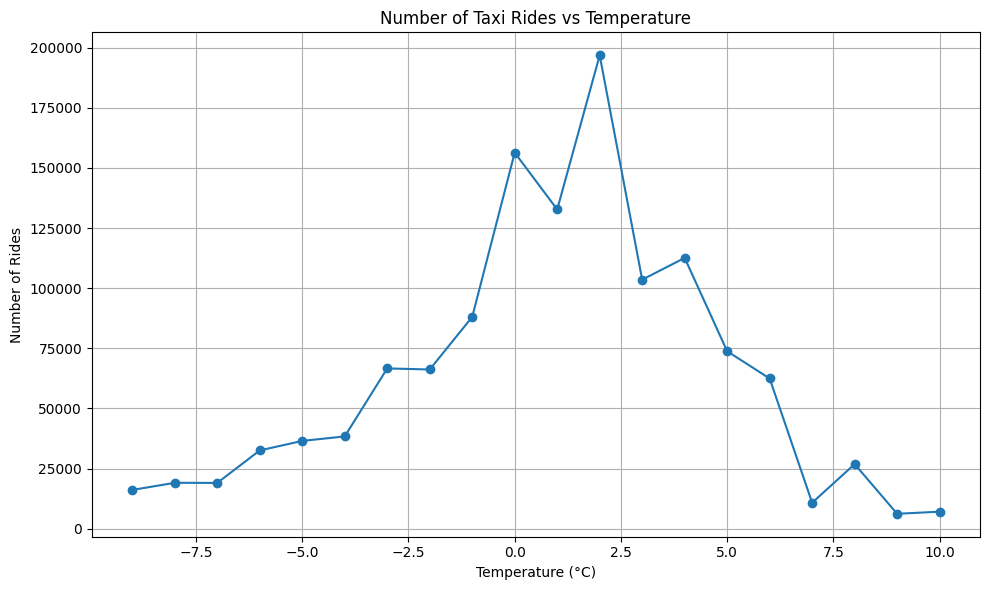

In [14]:
TripData_weather['temperature_rounded'] = TripData_weather['temperature_2m (°C)'].round()

temp_group = TripData_weather.groupby('temperature_rounded').size().reset_index(name='ride_count')

plt.figure(figsize=(10, 6))
plt.plot(temp_group['temperature_rounded'], temp_group['ride_count'], marker='o')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Rides')
plt.title('Number of Taxi Rides vs Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

This line plot illustrates the relationship between temperature (°C) and the number of taxi rides. The number of rides peaks sharply in the range [-1°C and 4°C,], suggesting that people heavily rely on taxis when it's cold but not extreme—likely to avoid discomfort while still being mobile. 
For very low temperatures [< -1°C], ride numbers are lower, possibly due to reduced outdoor activity in harsh cold. From, mild to warm temperatures [4 °C to 10°C], a noticeable drop in taxi rides is observed. Warmer conditions may encourage walking, biking, or using public transport instead.
Taxi demand is highest around freezing temperatures, indicating weather sensitivity. People are more likely to choose taxis when it's cold enough to be uncomfortable, but not cold enough to deter travel altogether.


### 4.2 Most Common Pickup-Zones

In [19]:
pickup_counts = TripZones.groupby('pickup_zone').size().reset_index(name='pickup_count')
pickup_counts = pickup_counts.sort_values(by='pickup_count', ascending=False)

print(pickup_counts.head(10))

                      pickup_zone  pickup_count
225         Upper East Side North         72589
226         Upper East Side South         71687
132               Lenox Hill West         45499
228         Upper West Side South         44490
177  Penn Station/Madison Sq West         43677
152                Midtown Center         43078
161                   Murray Hill         41841
133           Lincoln Square East         41120
153                  Midtown East         39952
131               Lenox Hill East         39875


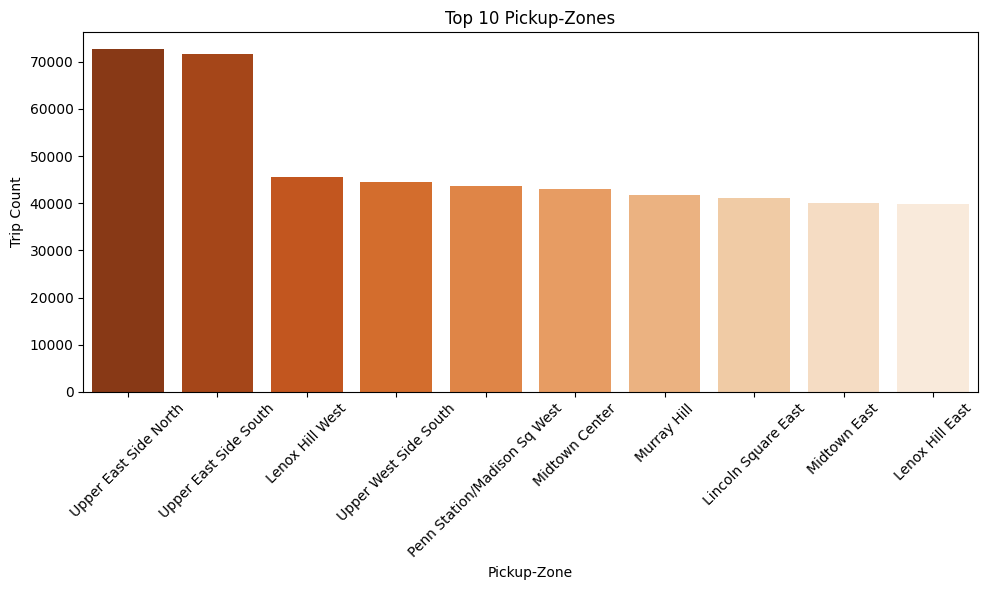

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=pickup_counts.head(10),
    y='pickup_count',
    x='pickup_zone',
    hue='pickup_zone',
    palette='Oranges_r',
    legend=False
)
plt.title('Top 10 Pickup-Zones')
plt.ylabel('Trip Count')
plt.xlabel('Pickup-Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This horizontal bar chart displays the top 10 taxi pickup zones based on trip volume. It reveals a right-skewed frequency distribution, with the first two zones (Upper East Side North and Upper East Side South) dominating the dataset (around 72,000+ trips each). This suggests a high concentration of demand in these zones. Zones ranked 3 to 10 show a gradual decline in trip count, ranging from around 45,000 to around 40,000 trips. The slope is relatively flat, indicating that these zones have comparable levels of demand, forming a plateau below the top two.
Many zones belong to Manhattan’s densely populated or commercial areas (e.g., Midtown, Lenox Hill, Penn Station), which likely reflects high pedestrian traffic, tourism, and business activity.
The Upper East Side accounts for a disproportionate share of ride activity, signalling potential hotspots for taxi availability, resource allocation, or pricing optimization.

#### 4.2.1 Heatmap

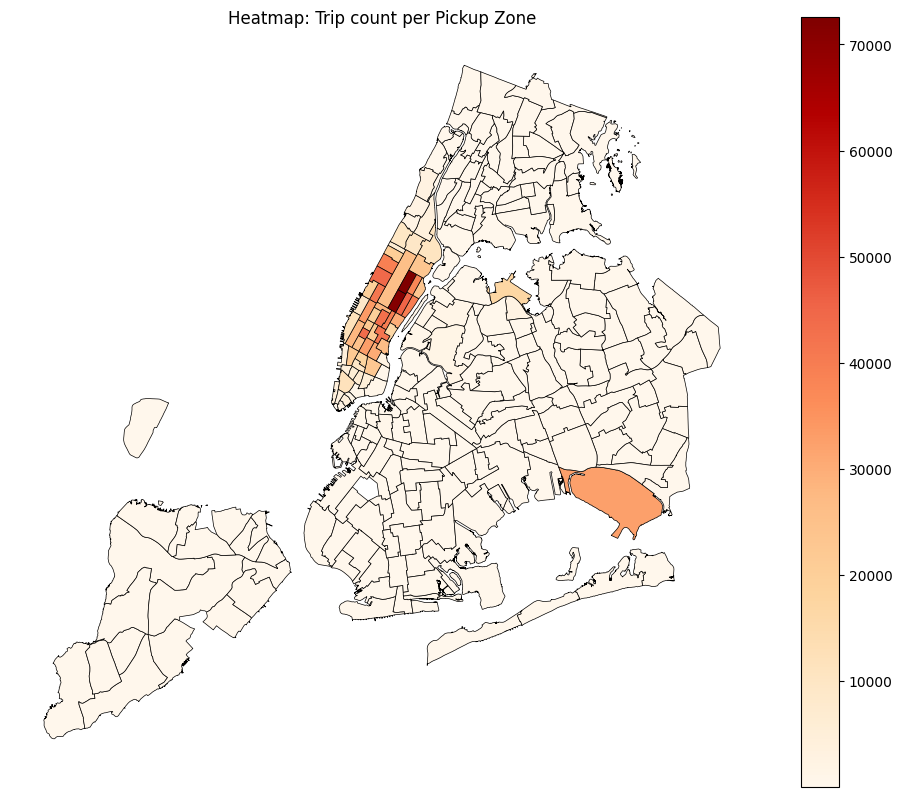

In [21]:
pickup_zone_stats = TripZones.groupby(
    ['pickup_zone', 'pickup_geometry']
).size().reset_index(name='count')

pickup_zone_stats = gpd.GeoDataFrame(pickup_zone_stats, geometry='pickup_geometry')

pickup_zone_stats.plot(
    column='count',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    figsize=(12, 10)
)
plt.title('Heatmap: Trip count per Pickup Zone')
plt.axis('off')
plt.show()
plt.show()

The heatmap confirms a strong spatial concentration of pickups in central Manhattan, especially the Upper East Side and Midtown. These zones show the highest intensity (70,000+ rides), while outer boroughs display significantly lower demand. The distribution is highly clustered, reflecting dense population, tourism, and commercial activity.

### 4.3 Most Common Dropoff-Zones

In [22]:
dropoff_counts = TripZones.groupby('zone_dropoff').size().reset_index(name='dropoff_count')
dropoff_counts = dropoff_counts.sort_values(by='dropoff_count', ascending=False)

print(dropoff_counts.head(10))

              zone_dropoff  dropoff_count
229  Upper East Side North          71954
230  Upper East Side South          61332
134        Lenox Hill West          43371
232  Upper West Side South          40996
231  Upper West Side North          39753
163            Murray Hill          39030
154         Midtown Center          37722
135    Lincoln Square East          37248
133        Lenox Hill East          36151
256         Yorkville West          34262


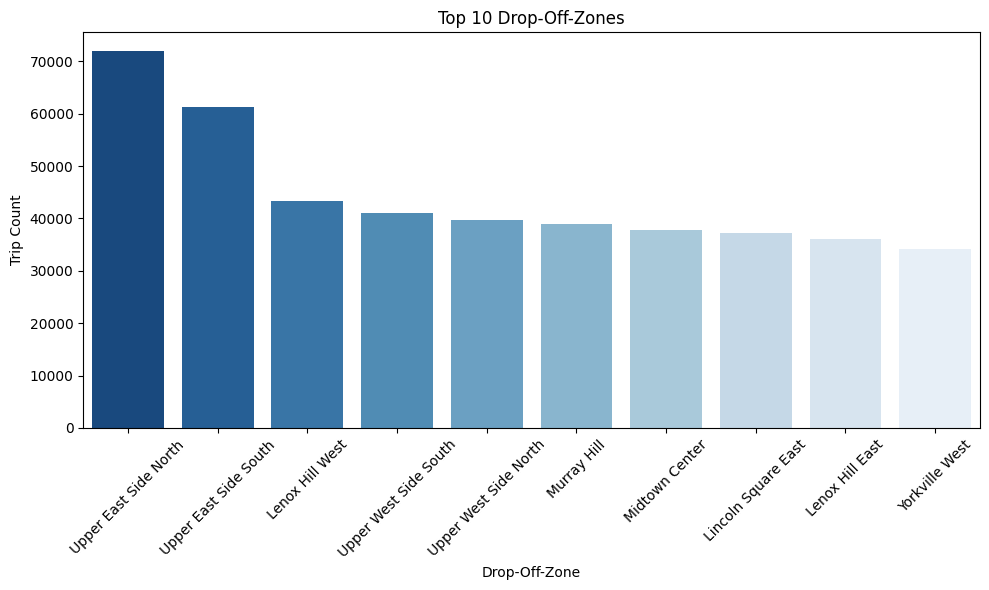

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=dropoff_counts.head(10),
    y='dropoff_count',
    x='zone_dropoff',
    hue='zone_dropoff',
    palette='Blues_r',
    legend=False
)
plt.title('Top 10 Drop-Off-Zones')
plt.ylabel('Trip Count')
plt.xlabel('Drop-Off-Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart ranks the top 10 drop-off zones by total trip count. The same two zones again lead the distribution, with Upper East Side North peaking at over 70,000 drop-offs. This mirrors the pickup pattern, indicating bidirectional demand concentration.
The remaining zones form a moderately flat tail, ranging between around 34,000 and around 43,000 trips. This suggests a more uniform distribution of drop-offs beyond the primary hotspots. Drop-off activity is heavily concentrated in a few zones—especially the Upper East Side—indicating consistent inbound and outbound flow.

### 4.4 Most Common Pairs 

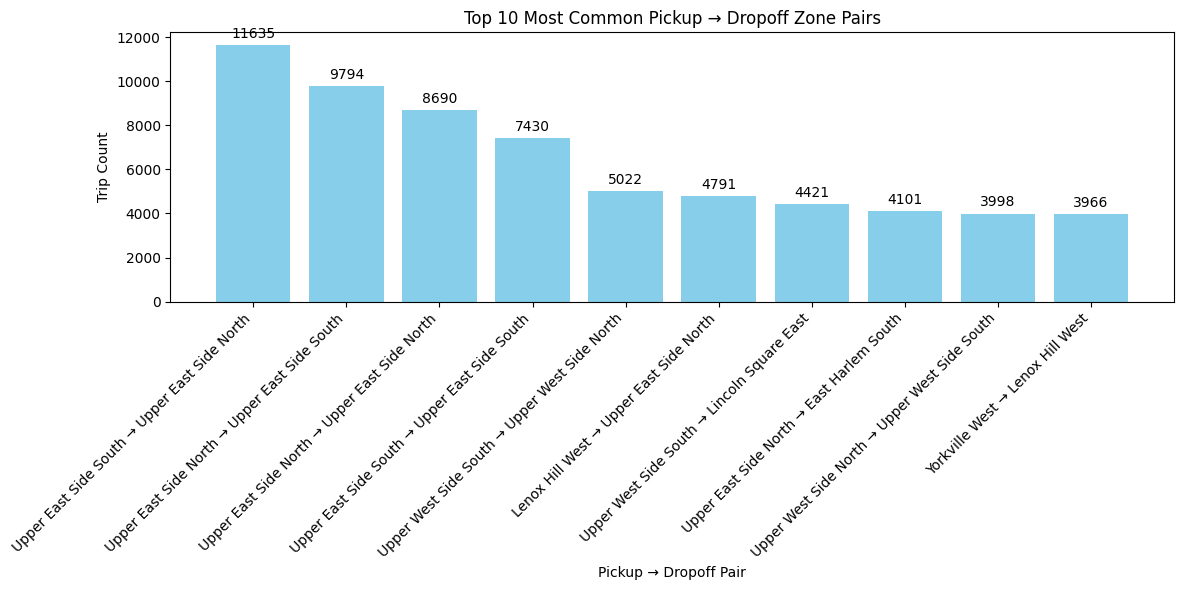

In [24]:
pair_counts = TripZones.groupby(['pickup_zone', 'zone_dropoff']).size().reset_index(name='trip_count')
top_10 = pair_counts.sort_values(by='trip_count', ascending=False).head(10)

top_10['pair'] = top_10['pickup_zone'] + " → " + top_10['zone_dropoff']
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10['pair'], top_10['trip_count'], color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset text upward
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.title('Top 10 Most Common Pickup → Dropoff Zone Pairs')
plt.xlabel('Pickup → Dropoff Pair')
plt.ylabel('Trip Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.5 Temporal Trip Patterns

#### 4.5.1 Time-of-Day Usage

In [25]:
TripData['tpep_pickup_datetime'] = pd.to_datetime(TripData['tpep_pickup_datetime'])

TripData['pickup_hour'] = TripData['tpep_pickup_datetime'].dt.hour

trips_per_hour = TripData.groupby('pickup_hour').size().reset_index(name='trip_count')

trips_per_hour = trips_per_hour.sort_values('pickup_hour')

print(trips_per_hour)

    pickup_hour  trip_count
0             0       11492
1             1        7494
2             2        4274
3             3        2466
4             4        2432
5             5        6455
6             6       21713
7             7       41313
8             8       63126
9             9       68222
10           10       75528
11           11       82354
12           12       90724
13           13       96271
14           14      105013
15           15      106414
16           16      100350
17           17       98865
18           18       89984
19           19       67341
20           20       45862
21           21       35782
22           22       29726
23           23       18216


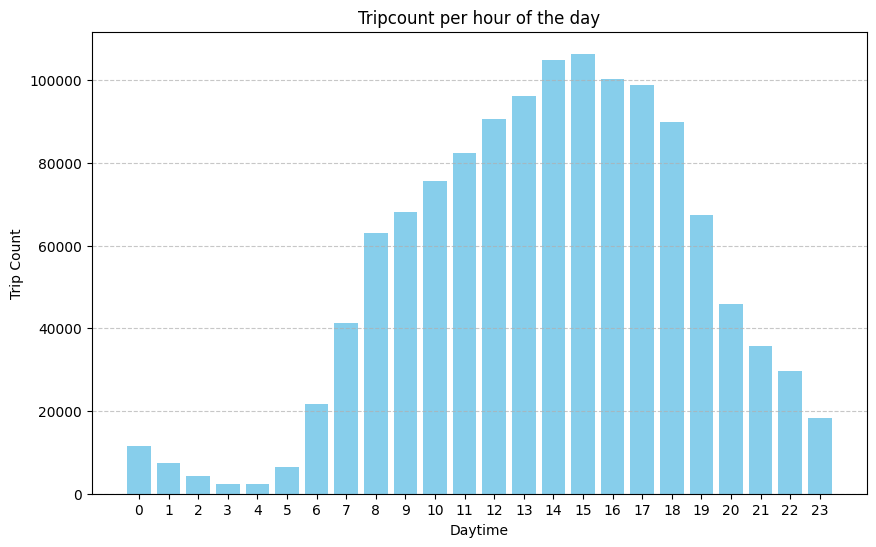

In [26]:
plt.figure(figsize=(10,6))
plt.bar(trips_per_hour['pickup_hour'], trips_per_hour['trip_count'], color='skyblue')
plt.xlabel('Daytime')
plt.ylabel('Trip Count')
plt.title('Tripcount per hour of the day')
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 4.5.2 Day-of-Week Usage

In [27]:
TripData['tpep_pickup_datetime'] = pd.to_datetime(TripData['tpep_pickup_datetime'])

TripData['pickup_weekday'] = TripData['tpep_pickup_datetime'].dt.dayofweek

weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
TripData['weekday_name'] = TripData['pickup_weekday'].apply(lambda x: weekday_names[x])

TripData['weekday_name'] = pd.Categorical(
    TripData['weekday_name'],
    categories=weekday_names,
    ordered=True
)

trips_per_weekday = TripData.groupby('weekday_name', observed=True).size().reset_index(name='trip_count')

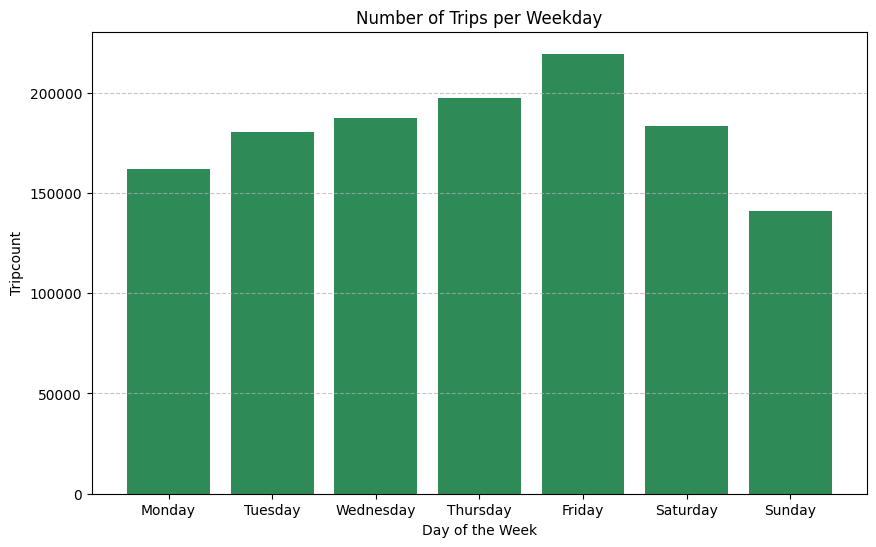

In [28]:
plt.figure(figsize=(10,6))
plt.bar(trips_per_weekday['weekday_name'], trips_per_weekday['trip_count'], color='seagreen')
plt.xlabel('Day of the Week')
plt.ylabel('Tripcount')
plt.title('Number of Trips per Weekday')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 5. Predictive Models

### 5.1 Random Forrest Regression
In our first model, we used a Random Forest Regression model to predict the number of taxi rides within a 30-minute time frame in a specific zone.
The target variable is `trip_count`, and the explanatory features are `temperature_2m (°C)`, `rain (mm)`, `hour`, `weekday`, and `PULocationID`.
We applied one-hot encoding to convert `PULocationID` into dummy variables.

In [ ]:
y = stats['trip_count']
X = stats[['temperature_2m (°C)', 'rain (mm)', 'hour', 'weekday', 'PULocationID']]
X = pd.get_dummies(X, columns=['PULocationID'], drop_first=True)

#### 5.1.1 Data-Split
For this model, we used a data split of 60% training, 20% validation, and 20% test data.

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=False)

#### 5.1.2. Hyper-Parameter Optimization
In order to optimize our hyperparameters, we used the Grid Search algorithm.

In [ ]:
param_grid = { #Defining Parameter Grid
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid = GridSearchCV( #Initialising Grid Search
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2   # zeigt Fortschritt jeder Kombination
)
grid.fit(X_train, y_train) #Starting the Grid Search
print("Best R² on validation folds:", grid.best_score_)
print("Beste Parameter:", grid.best_params_)

#### 5.1.3.Model-Training and Testing
The model was trained and tested using the hyperparameters identified through grid search.

In [ ]:
best_rf = grid.best_estimator_ #Using the best Hyperparameters from our Gridsearch
X_full_train = pd.concat([X_train, X_val]) #combining training and validation Data
y_full_train = pd.concat([y_train, y_val]) #combining training and validation Data
best_rf.fit(X_full_train, y_full_train) #Model is trained on combined training Dataset
y_pred = best_rf.predict(X_test) #Trained Model is used, to make a prediction for the Testdata
print("Finaler R² (Testset):", r2_score(y_test, y_pred))
print("Finales MSE (Testset):", mean_squared_error(y_test, y_pred))

---
### Second Machine Learning Model: Gradient Boosting with Enhanced Data Preparation
*Note: The original data and models are left untouched. This section explores a new data aggregation approach for improved predictive accuracy.*
*New R2 score is 0.6706 and the MSE is 5704.9795*

Starting improved data preparation for the new model...
New 'stats_neu' table for training created. Shape: (19432, 6)
New training and test data ('X_train_neu', etc.) created.
--------------------------------------------------

Starting Gradient Boosting model training with new data...

--- NEW MODEL RESULTS ---
Gradient Boosting (improved) - R2 Score: 0.6706
Gradient Boosting (improved) - Mean Squared Error (MSE): 5704.9795

Creating visualization...


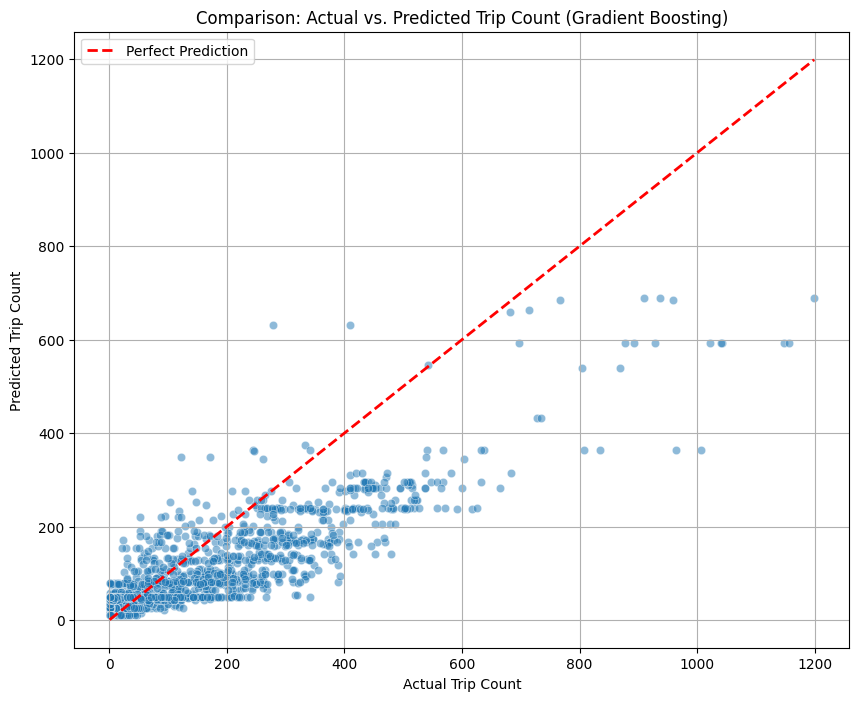

In [21]:
# --- data prep for new model ---
print("Starting improved data preparation for the new model...")

df_model_neu = TripData_weather.copy()
# extract features
df_model_neu['hour'] = df_model_neu['tpep_pickup_datetime'].dt.hour
df_model_neu['weekday'] = df_model_neu['tpep_pickup_datetime'].dt.dayofweek

# aggregation
trip_counts_neu = df_model_neu.groupby(['PULocationID', 'hour', 'weekday']).size().reset_index(name='trip_count')

# add weather data
weather_avg_neu = df_model_neu.groupby(['hour', 'weekday']).agg({
    'temperature_2m (°C)': 'mean',
    'rain (mm)': 'mean'
}).reset_index()

# merge
stats_neu = pd.merge(trip_counts_neu, weather_avg_neu, on=['hour', 'weekday'])

print("New 'stats_neu' table for training created. Shape:", stats_neu.shape)

# define x and y
y_neu = stats_neu['trip_count']
X_neu = stats_neu.drop('trip_count', axis=1)

# one-hot encoding
X_neu = pd.get_dummies(X_neu, columns=['PULocationID'], drop_first=True)

# scaling & split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_neu = StandardScaler()
X_scaled_neu = scaler_neu.fit_transform(X_neu)

X_train_neu, X_test_neu, y_train_neu, y_test_neu = train_test_split(
    X_scaled_neu, y_neu, test_size=0.2, random_state=42
)

print("New training and test data ('X_train_neu', etc.) created.")
print("-" * 50)


# --- gradient boosting model ---
print("\nStarting Gradient Boosting model training with new data...")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# create & train model
gb_model_neu = GradientBoostingRegressor(random_state=42)
gb_model_neu.fit(X_train_neu, y_train_neu)

# predict
y_pred_gb_neu = gb_model_neu.predict(X_test_neu)

# evaluate
r2_gb_neu = r2_score(y_test_neu, y_pred_gb_neu)
mse_gb_neu = mean_squared_error(y_test_neu, y_pred_gb_neu)

print("\n--- NEW MODEL RESULTS ---")
print(f"Gradient Boosting (improved) - R2 Score: {r2_gb_neu:.4f}")
print(f"Gradient Boosting (improved) - Mean Squared Error (MSE): {mse_gb_neu:.4f}")


# --- visualization ---
print("\nCreating visualization...")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_neu, y=y_pred_gb_neu, alpha=0.5)
# ideal line (x=y)
plt.plot([y_test_neu.min(), y_test_neu.max()], [y_test_neu.min(), y_test_neu.max()], '--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('Comparison: Actual vs. Predicted Trip Count (Gradient Boosting)')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.legend()
plt.grid(True)
plt.show()